In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix

In [124]:
exclude_labels = [0] # colocar aqui as labels que quiser descartar
train = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet').sample(frac=1)
train = train[~train['label'].isin(exclude_labels)]
train_matrices = train.iloc[:, 1:].values.reshape(-1, 500, 52).transpose(0, 2, 1).astype(np.float16)
scale_factor = train_matrices.mean()

test = pd.read_parquet('./data/TEST_person3_car2_dog3_cow2_noise3.parquet').sample(frac=1)
test = test[~test['label'].isin(exclude_labels)]
test_matrices = test.iloc[:, 1:].values.reshape(-1, 500, 52).transpose(0, 2, 1).astype(np.float16)

train_carrier_means = train_matrices.mean(axis=2)
train_carrier_stds = train_matrices.std(axis=2)

test_carrier_means = test_matrices.mean(axis=2)
test_carrier_stds = test_matrices.std(axis=2)

train_features = np.concatenate([train_carrier_means, train_carrier_stds], axis=1)
test_features = np.concatenate([test_carrier_means, test_carrier_stds], axis=1)

In [138]:
print(train_features.shape)
print(test_features.shape)

(1106, 104)
(301, 104)


In [28]:
label_map = {
    0: 'background',
    1: 'person',
    2: 'car',
    3: 'dog',
    4: 'cow'
}


train_means_df = pd.DataFrame(train_carrier_means, columns=[f'c{i}' for i in range(52)])
train_means_df['label'] = train['label'].reset_index(drop=True).apply(lambda x: label_map[x])
train_means_df

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c43,c44,c45,c46,c47,c48,c49,c50,c51,label
0,-81.5625,-81.6875,-81.8125,-81.9375,-82.0000,-82.0625,-82.1250,-82.1875,-82.2500,-82.3125,...,-80.1250,-80.0625,-80.0000,-80.0000,-80.0000,-80.0000,-80.0000,-79.9375,-79.8750,dog
1,-83.4375,-83.5625,-83.5625,-83.6250,-83.5625,-83.5625,-83.5000,-83.3750,-83.3125,-83.1875,...,-83.5625,-83.5625,-83.5625,-83.6875,-83.8125,-83.9375,-83.9375,-84.0000,-84.0625,car
2,-79.5625,-79.6250,-79.6875,-79.6875,-79.6250,-79.6250,-79.5625,-79.4375,-79.4375,-79.3750,...,-80.6875,-80.5625,-80.5000,-80.5000,-80.5625,-80.5625,-80.5625,-80.5625,-80.5000,cow
3,-80.8750,-81.0000,-81.1250,-81.2500,-81.3750,-81.4375,-81.5000,-81.5625,-81.6875,-81.7500,...,-80.1875,-80.1250,-80.0625,-80.0625,-80.0625,-80.1250,-80.0625,-80.0625,-79.9375,dog
4,-79.5000,-79.5625,-79.6250,-79.5625,-79.5000,-79.5000,-79.3750,-79.3125,-79.2500,-79.1875,...,-80.6875,-80.5625,-80.4375,-80.3750,-80.5000,-80.5000,-80.5000,-80.5000,-80.4375,cow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,-83.6250,-83.7500,-83.8125,-83.8125,-83.7500,-83.6875,-83.6250,-83.5000,-83.3125,-83.1250,...,-83.5625,-83.5625,-83.6250,-83.7500,-83.8750,-84.0000,-84.0625,-84.1250,-84.1875,car
1102,-78.2500,-78.3125,-78.3125,-78.3750,-78.4375,-78.5000,-78.5625,-78.5625,-78.6875,-78.8125,...,-81.8750,-81.8125,-81.7500,-81.7500,-81.7500,-81.7500,-81.6875,-81.6875,-81.6250,dog
1103,-80.5000,-80.5625,-80.6250,-80.5625,-80.4375,-80.3750,-80.3125,-80.2500,-80.1875,-80.1250,...,-81.4375,-81.3125,-81.1875,-81.0625,-81.1250,-81.1875,-81.1250,-81.1250,-81.1250,cow
1104,-79.6250,-79.6250,-79.6250,-79.5000,-79.4375,-79.3125,-79.2500,-79.1250,-79.0625,-79.0625,...,-80.5000,-80.4375,-80.3750,-80.3750,-80.5000,-80.6250,-80.6250,-80.6875,-80.6875,cow


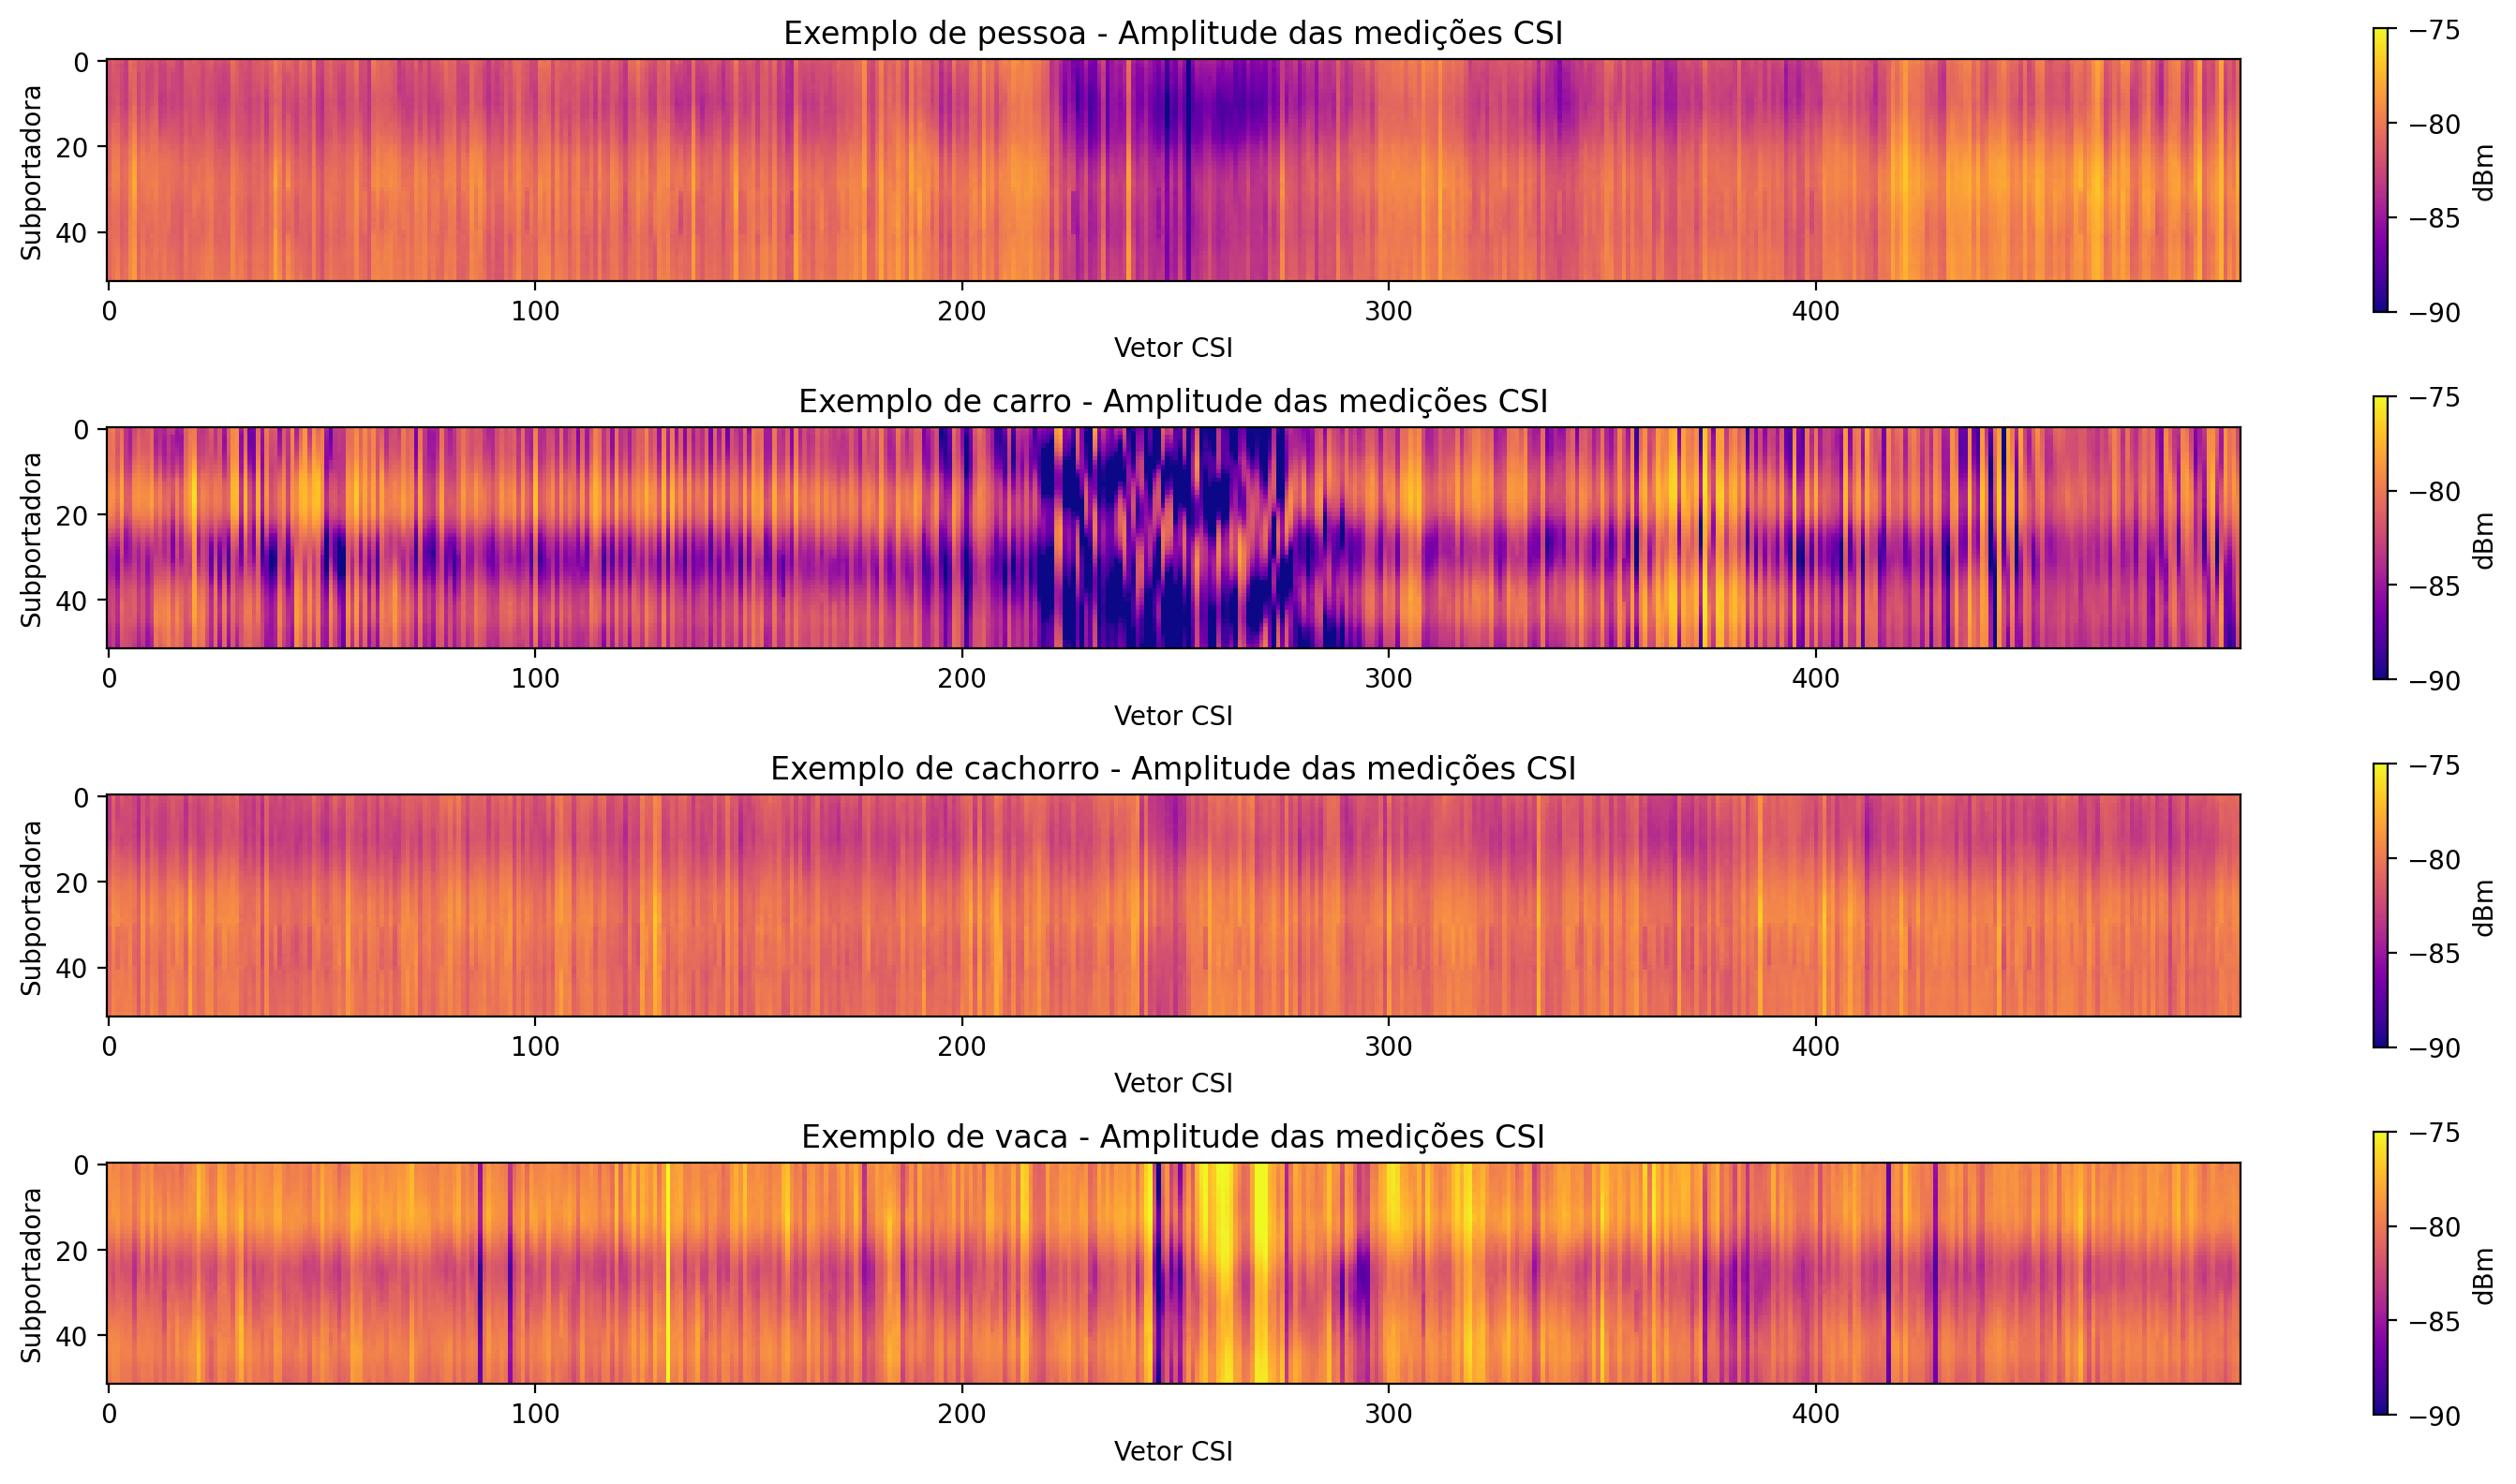

In [103]:
# Print examples
label_map_pt = {
    1: 'pessoa',
    2: 'carro',
    3: 'cachorro',
    4: 'vaca'
}

examples = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet')

fig, ax = plt.subplots(4, 1, figsize=(15, 8), dpi=200)
for i, (label, name) in enumerate(label_map_pt.items()):
    filtered_df = examples[examples.label == label]
    example = filtered_df.iloc[10, 1:].values.reshape(500, 52).transpose(1, 0)
    im = ax[i].imshow(example, vmin=-90, vmax=-75, cmap='plasma')
    ax[i].set_title(f'Exemplo de {name} - Amplitude das medições CSI')
    ax[i].set_xlabel('Vetor CSI')
    ax[i].set_ylabel('Subportadora')
    plt.colorbar(im, ax=ax[i], label='dBm')


plt.tight_layout()
plt.show()

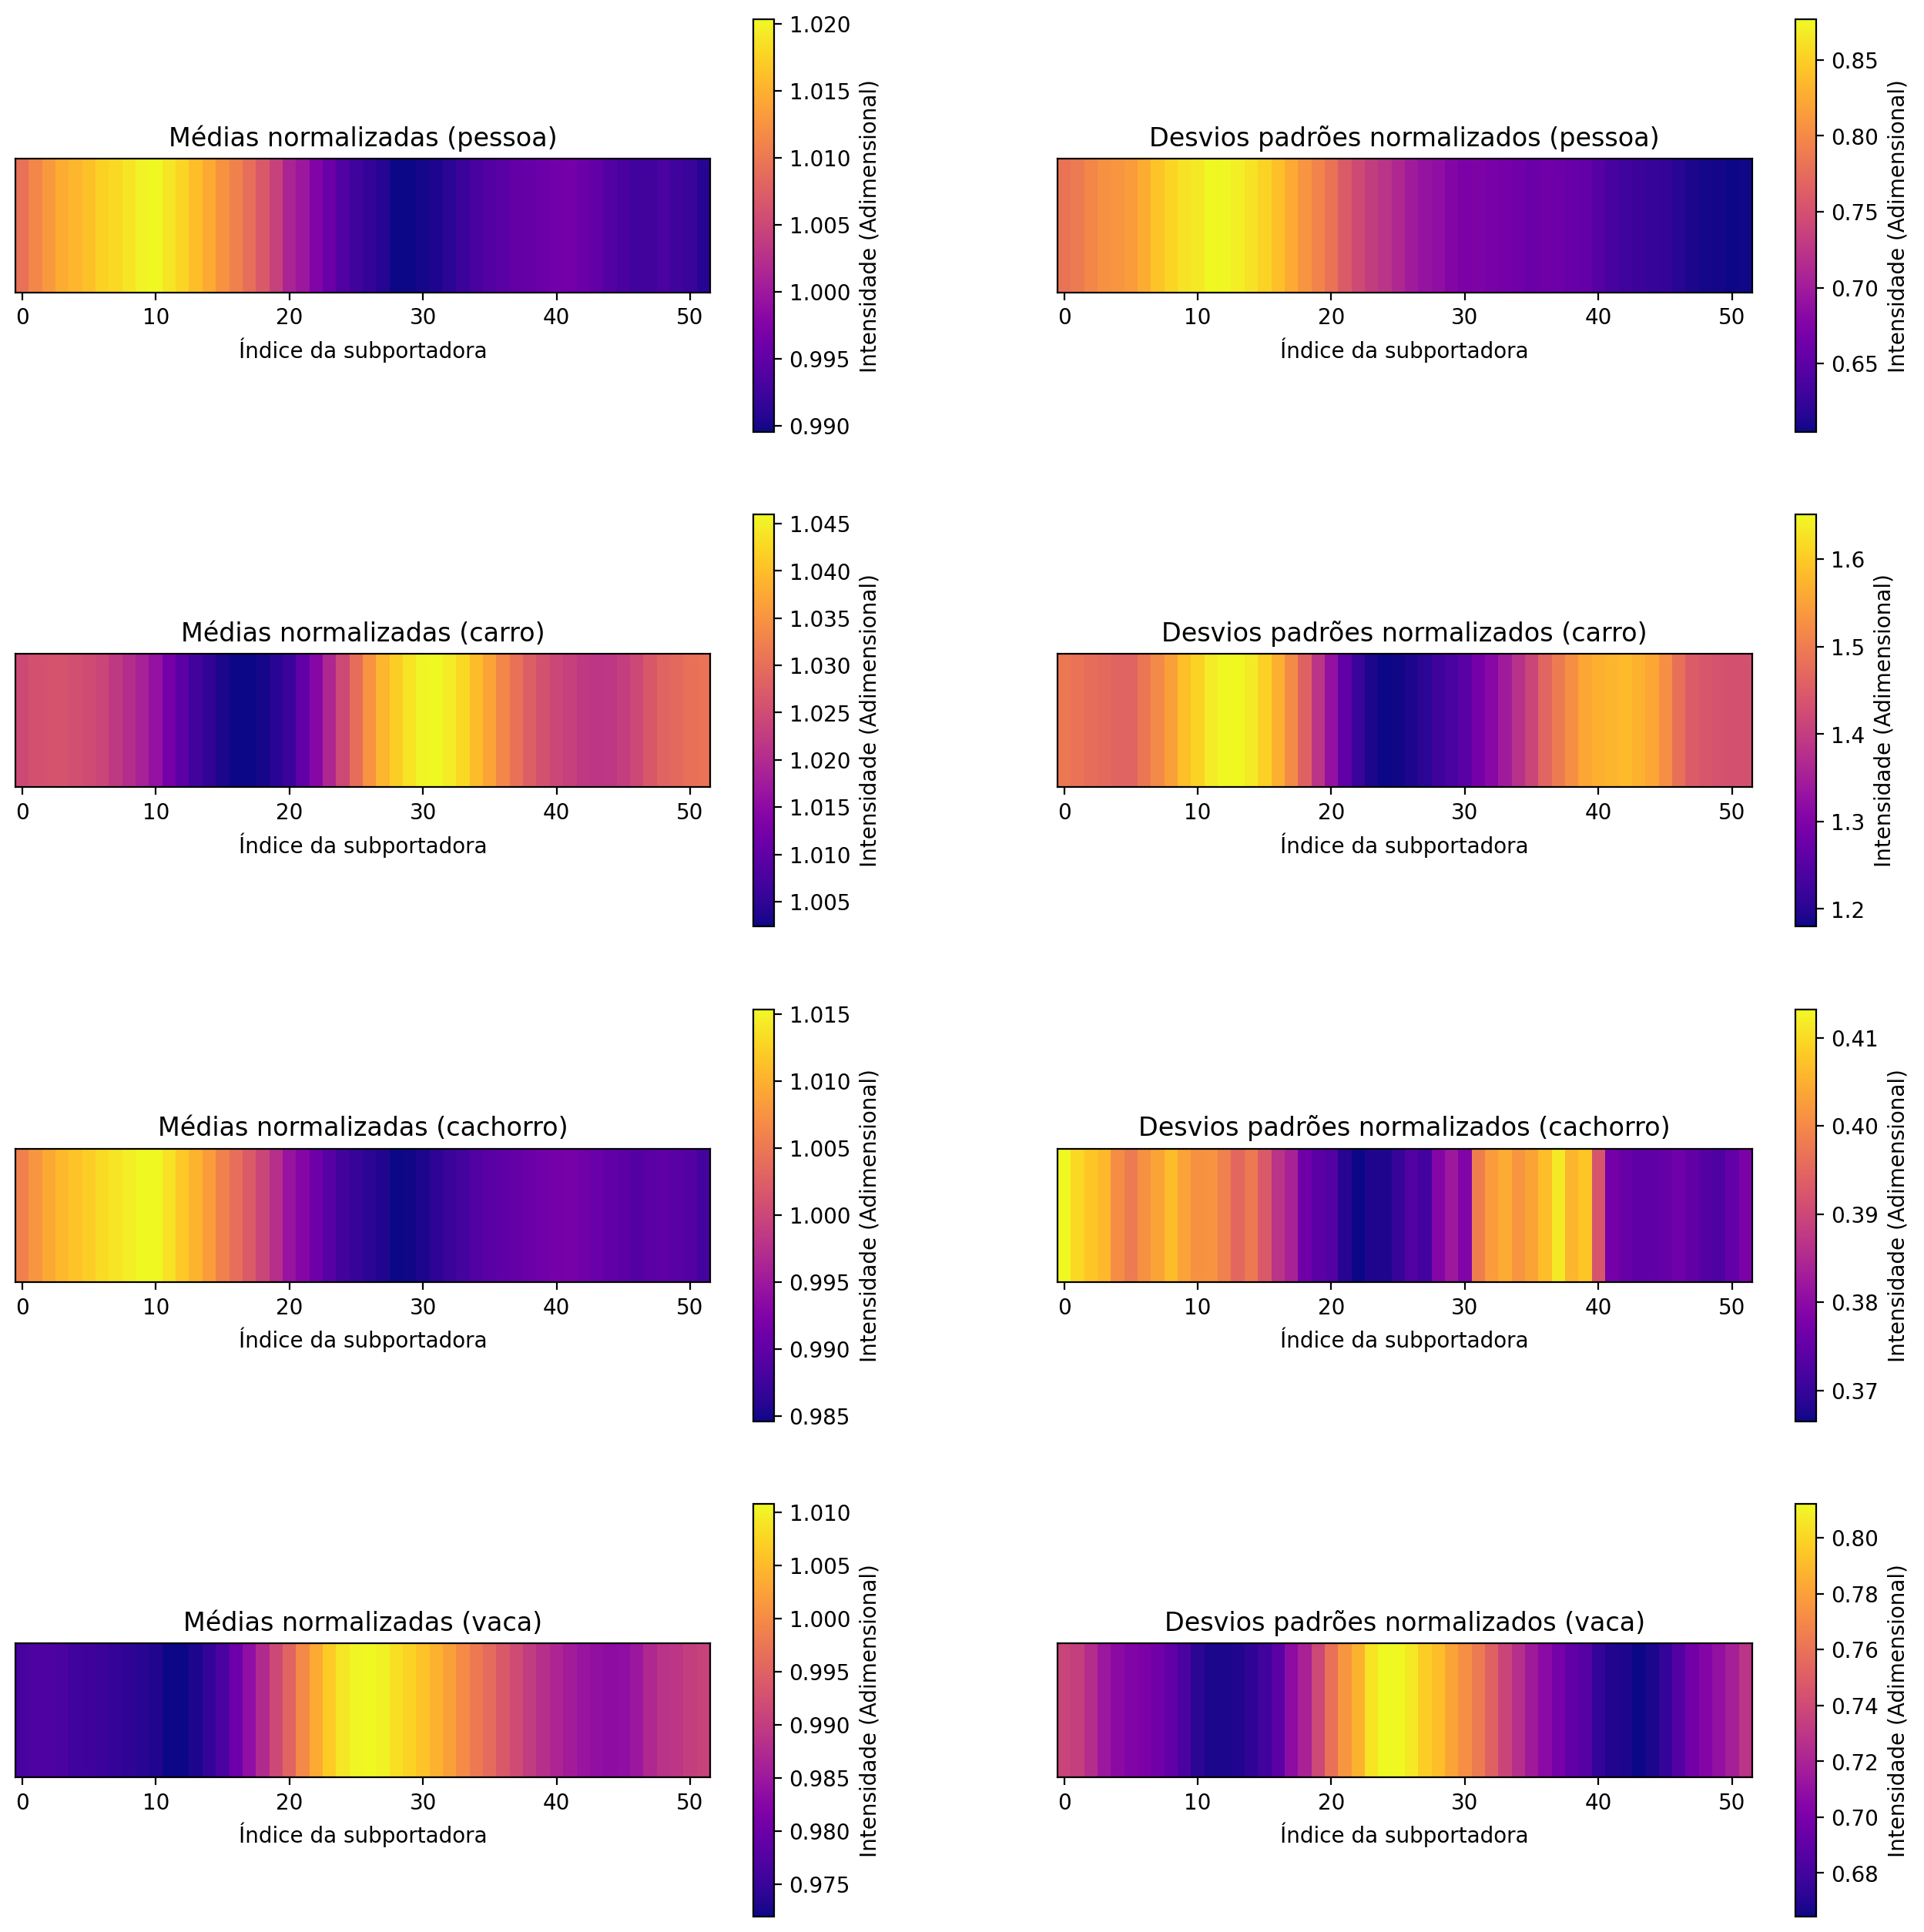

In [104]:
# Print examples
examples = pd.read_parquet('./data/TRAIN_person3_car2_dog3_cow2_noise3.parquet')

fig, ax = plt.subplots(4, 2, figsize=(16, 16), dpi=200)
for i, (label, name) in enumerate(label_map_pt.items()):
    filtered_df = examples[examples.label == label]
    example = filtered_df.iloc[10, 1:].values.reshape(500, 52).transpose(1, 0)
    example_carrier_means = example.mean(axis=1) / train_carrier_means.mean()
    example_carrier_stds = example.std(axis=1) / train_carrier_stds.mean()

    im = ax[i][0].imshow(np.expand_dims(example_carrier_means, axis=0), aspect=10, cmap='plasma')
    ax[i][0].set_title(f'Médias normalizadas ({name})')
    ax[i][0].set_xlabel('Índice da subportadora')
    ax[i][0].set_yticks([])
    plt.colorbar(im, ax=ax[i][0], label='Intensidade (Adimensional)')

    im = ax[i][1].imshow(np.expand_dims(example_carrier_stds, axis=0), aspect=10, cmap='plasma')
    ax[i][1].set_title(f'Desvios padrões normalizados ({name})')
    ax[i][1].set_xlabel('Índice da subportadora')
    ax[i][1].get_yaxis().set_visible(False)
    plt.colorbar(im, ax=ax[i][1], label='Intensidade (Adimensional)')


plt.show()

In [122]:


model = KNeighborsClassifier(n_neighbors=100)
model.fit(train_features, train['label'])
preds = model.predict(test_features)
print(accuracy_score(test['label'], preds))

0.9102990033222591


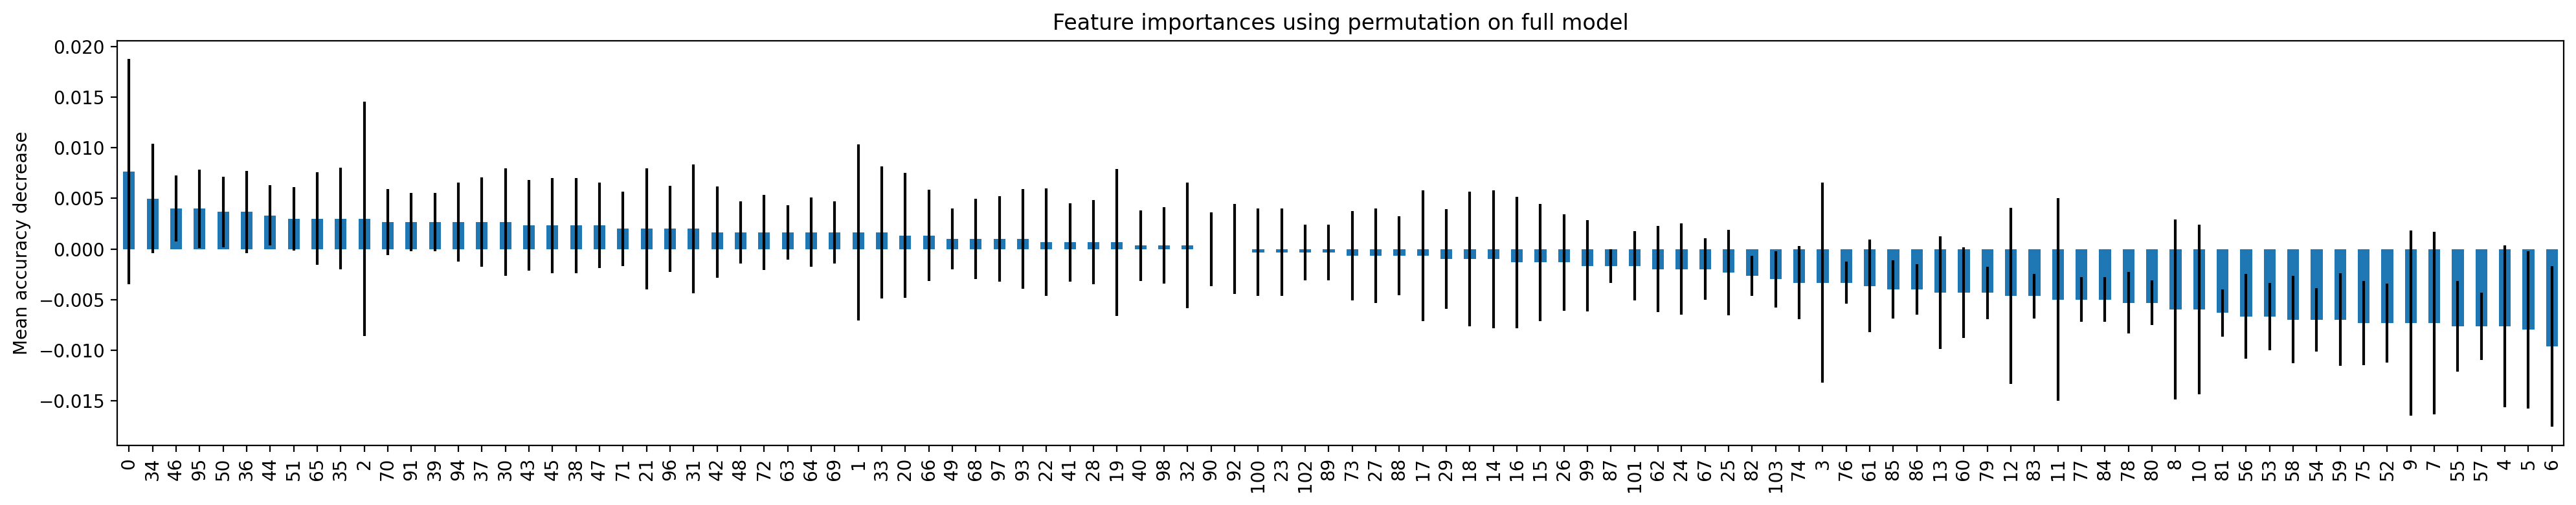

In [144]:
result = permutation_importance(model, test_features, test['label'], n_repeats=10, random_state=1)
importances = pd.DataFrame(data={'mean': result.importances_mean, 'std': result.importances_std})
importances = importances.sort_values('mean', ascending=False)

fig, ax = plt.subplots(dpi=200, figsize=(20, 4))
importances['mean'].plot.bar(yerr=importances['std'], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [145]:
important_features = importances.index[importances['mean'] > 0]
print(important_features)
print(important_features.shape)

Int64Index([ 0, 34, 46, 95, 50, 36, 44, 51, 65, 35,  2, 70, 91, 39, 94, 37, 30,
            43, 45, 38, 47, 71, 21, 96, 31, 42, 48, 72, 63, 64, 69,  1, 33, 20,
            66, 49, 68, 97, 93, 22, 41, 28, 19, 40, 98, 32],
           dtype='int64')
(46,)


In [146]:
train_features[:, important_features].shape

(1106, 46)

In [147]:

model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_features[:, important_features], train['label'])
preds = model.predict(test_features[:, important_features])
print(accuracy_score(test['label'], preds))

0.9534883720930233


In [148]:
train_features[:, important_features].itemsize * train_features[:,important_features].size / 1000

101.752

In [149]:
confusion_matrix(test['label'], preds)

array([[92,  0,  6,  0],
       [ 1, 62,  0,  0],
       [ 7,  0, 77,  0],
       [ 0,  0,  0, 56]])